In [3]:
!pip install --upgrade pip
!pip install git+https://github.com/jpmorganchase/QOKit.git
!pip install qiskit[visualization] qiskit-optimization qiskit-aer
!pip install qiskit-aer-gpu
!pip install pennylane


  Cloning https://github.com/jpmorganchase/QOKit.git to /tmp/pip-req-build-54hw7scr
  Running command git clone --filter=blob:none --quiet https://github.com/jpmorganchase/QOKit.git /tmp/pip-req-build-54hw7scr
  Resolved https://github.com/jpmorganchase/QOKit.git to commit cbb6eb5963f4c2495c15368c2bfd723ade871e78
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
zsh:1: no matches found: qiskit[visualization]


# Q1: Grover's Algorithm

In this problem, you'll implement Grover's algorithm from scratch in `qiskit`.
In particular, we will be searching for 3-bit strings with exactly one "1."

## Part A: Introducing the CCZ gate
The `qiskit` circuit library includes a gate called the [CCZ gate](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.CCZGate). How does the CCZ gate transform computational basis states? Is there a geometric interpretation of this operator?

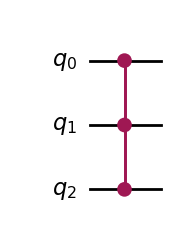

In [4]:
# Here's an example of applying a CCZ gate (you don't have to do anything in this cell)
from qiskit import QuantumCircuit
qc = QuantumCircuit(3)
qc.ccz(0,1,2)
qc.draw(output='mpl')

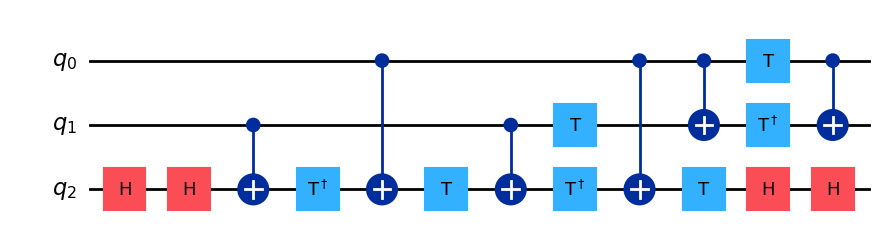

In [5]:
# In case you're curious, here's how we can compile the ccz gate into single qubit and two-qubit gates (you don't have to do anything in this cell)
from qiskit import QuantumCircuit
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import BasisTranslator
from qiskit.circuit.equivalence_library import StandardEquivalenceLibrary as sel
qc = QuantumCircuit(3)
qc.ccz(0,1,2)
pm = PassManager(
            [BasisTranslator(equivalence_library=sel, target_basis=["t", "tdg", "h", "x", "cx"])]
        )
transpiled_circuit = pm.run(qc)
transpiled_circuit.draw(output='mpl')

# Part A Solution (TODO)

CCZ gate flip the phase of the current state if all the bit in the bitstring is '1'.

![](https://learning-api.quantum.ibm.com/assets/c6e82dd7-81c9-4078-a952-139c8c5aabca?format=auto&quality=80)

Geometrically, this operation can be represent in the following image which $|A_1\rangle$ is $|111\rangle$ and $|A_0\rangle$ is unitary superposition of all other bitstrings.

## Part B: Defining the Grover Oracle

Consider the following function:

$$f(x) = 	 \begin{cases}
  1  & x \text{ contains exactly one 1} \\
  0 & \text{otherwise}
\end{cases}
$$

For example, $f(001) = 1$, but $f(110) = f(000) =  0.$

Based on the discussion from class, implement an oracle operator for $f$.
Recall that the  oracle $U$ should have the following behavior on computational basis states:

$$U|x\rangle =	 \begin{cases}
  |x\rangle & f(x)=0\\
  -|x\rangle & f(x)=1\\
\end{cases}
$$

Fill in the function `grover_oracle` below to return the desired circuit.

Your oracle operator should act on three qubit, with no additional ancilla qubits.

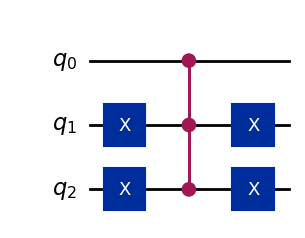

In [6]:
from qiskit import QuantumCircuit
def grover_oracle():
  # Fill in the oracle operator here
  circ = QuantumCircuit(3)
  circ.x(1)
  circ.x(2)
  circ.ccz(0, 1, 2)
  circ.x(1)
  circ.x(2)
  return circ

grover_oracle().draw('mpl')

## Part C: Defining the Diffusion Operator
Fill in the function `grover_diffusion_operator` below to return the Grover diffusion ("inversion about the mean") operator over three qubits:

$$D = \mathbb{I} - 2|s⟩⟨s|$$


*Hint: Remember that we can think about this operator in three parts: rotate the equal superposition to $|000\rangle$, reflect about $|000\rangle$, then undo the initial rotation.*

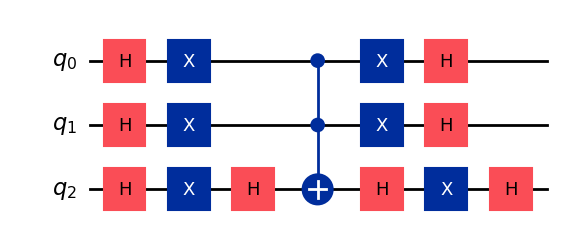

In [7]:
from qiskit import QuantumCircuit
def grover_diffusion_operator():
  # Fill in the diffusion operator here
  circ = QuantumCircuit(3)
  circ.h([0, 1, 2])
  circ.x([0, 1, 2])
  circ.h(2)
  circ.ccx(0, 1, 2)
  circ.h(2)
  circ.x([0, 1, 2])
  circ.h([0, 1, 2])
  return circ

grover_diffusion_operator().draw('mpl')

# Part D: Simulating the search
The function `grover_circuit` below can be used to build a circuit that performs a given number of iterations of Grover's algorithm (assuming you've implemented the two functions above!). We'll use it to simulate the search.

Theoretical analysis tells us that the optimal number of iterations of Grover's algorithm is approximately
$$
\lceil \frac{\pi}{4} \sqrt{\frac{N}{M}} \rceil
$$

where N is the number of marked states and M is the total number of states.

Construct the circuit for $k-1, k,$ and $k+1$ iterations where
$
k = \lceil \frac{\pi}{4} \sqrt{\frac{N}{M}} \rceil
$, and simulate each circuit for 1024 shots.

Plot a histogram of measurement outcomes for each.

 Which gives you the highest probability of success?

In [8]:
# You don't have to do anything in this cell
from qiskit import QuantumCircuit
def grover_circuit(iterations=1):
  qc = QuantumCircuit(3)
  qc.h(range(3))
  for iters in range(iterations):
    qc.compose(grover_oracle(), inplace=True)
    qc.compose(grover_diffusion_operator(), inplace=True)
  qc.measure_all()
  return qc

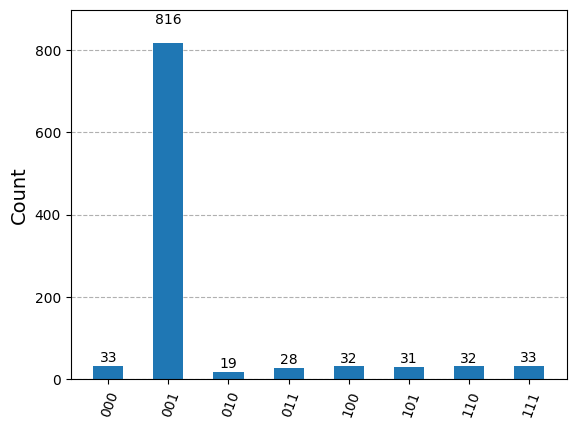

In [9]:
# Add your simulation code here
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import math
simulator = AerSimulator()
results = simulator.run(grover_circuit( math.ceil(math.pi / 4 * math.sqrt(1 / 2**3))), shot=1024).result()
plot_histogram(results.get_counts())

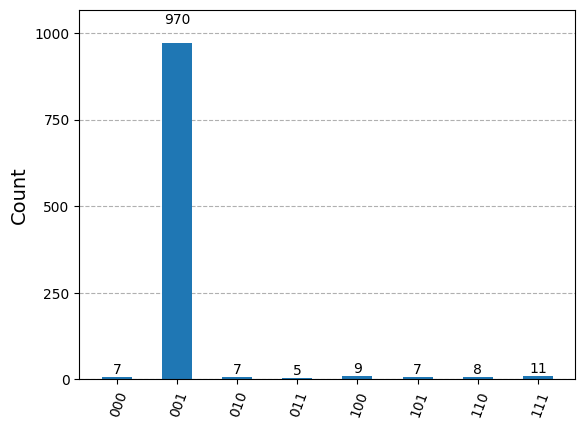

In [10]:
results = simulator.run(grover_circuit( math.ceil(math.pi / 4 * math.sqrt(1 / 2**3)) + 1), shot=1024).result()
plot_histogram(results.get_counts())

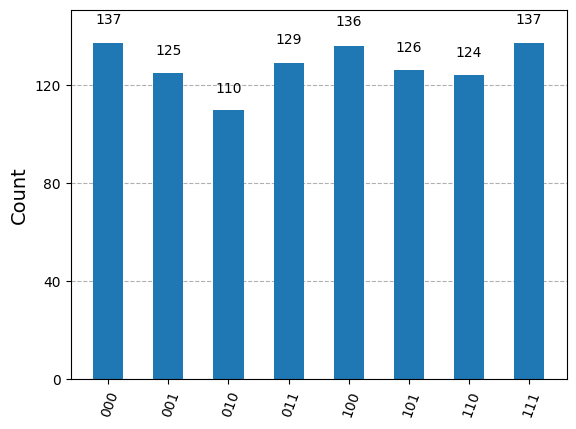

In [11]:
results = simulator.run(grover_circuit( math.ceil(math.pi / 4 * math.sqrt(1 / 2**3))-1), shot=1024).result()
plot_histogram(results.get_counts())

## Part D Response (TODO)

Based on the result of simulation, $K$ iterations get a relative nice result,
$K + 1$ iterations get the best result. But $K - 1$ iterations' result cannot be used at all.

# Q2: QAOA

In this problem, we will use Qiskit to build QAOA instances to solve MaxCut problems.

## Q2 (a)
Follow the instructions to complete the implementation. When you don't know how to use a function, search for its documentation.

First, we will create the graph for the MaxCut problem. Use `networkx`'s `random_regular_graph()` to generate a **3**-regular graph with 10 nodes. Use seed 6657.

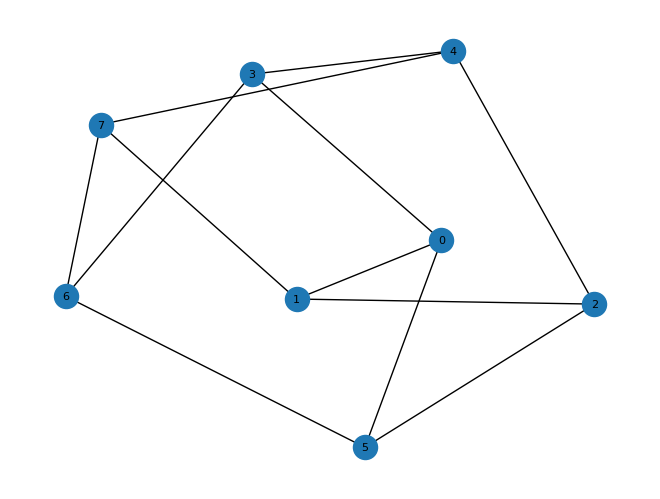

In [12]:
import networkx as nx

n = 8
seed = 6657

graph = nx.random_regular_graph(3, n, seed)
nx.draw(graph, with_labels=True, node_size=300, font_size=8)

Next, use the `Maxcut` class from `qiskit_optimization` to instantiate the problem. Construct the Hamiltonian with `.to_quadratic_program()` and `.to_ising()`.

In [13]:
# TOD
!pip install qiskit-optimization

from qiskit_optimization.applications import Maxcut
max_cut = Maxcut(graph)
hamiltonian, offset = max_cut.to_quadratic_program().to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(hamiltonian))


Offset: -6.0
Ising Hamiltonian:
SparsePauliOp(['IIIIIIZZ', 'IIIIZIIZ', 'IIZIIIIZ', 'IIIIIZZI', 'ZIIIIIZI', 'IIIZIZII', 'IIZIIZII', 'IIIZZIII', 'IZIIZIII', 'ZIIZIIII', 'IZZIIIII', 'ZZIIIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


Let's use a classical approach, `NumPyMinimumEigensolver` in `qiskit_algorithms`, to compute the true ground state energy of the Hamiltonian, which corresponds to the negative of the maximum cut of this problem instance.
We will use it as the denominator in approximate ratio (AR) calculation.  (Nothing to be done in this code block.)

In [14]:
from qiskit_algorithms import NumPyMinimumEigensolver

ground_state_energy = NumPyMinimumEigensolver().compute_minimum_eigenvalue(hamiltonian).eigenvalue.real + offset
print(ground_state_energy)

-10.0


It is important to supply a high quality initial point for QAOA. Here we use package `qokit`. (Nothing to be done in this code block.)

In [15]:
import numpy as np
from qokit.parameter_utils import get_fixed_gamma_beta

def get_initial_point(p):
    gamma, beta = get_fixed_gamma_beta(3, p)
    return np.concatenate([-np.array(beta), np.array(gamma) / 2]) # make up for different conventions

Finally, use the preparations above and the starter code below to write a function that takes in the QAOA depth (as known as $p$) and outputs the approximation ratio of the found solution.

In [16]:
from qiskit_aer.noise import NoiseModel
from qiskit_aer.primitives import Sampler
from qiskit_algorithms.minimum_eigensolvers import QAOA
from qiskit_algorithms.optimizers import COBYLA

# TODO
def run_qaoa(depth: int, noise_model: NoiseModel | None = None) -> float:
    sampler = Sampler(
        run_options={"shots": 10000, "seed": seed},
        backend_options={"noise_model": noise_model, "device": "CPU"}
    )

    optimizer = COBYLA(maxiter=10000)
    initial_point = get_initial_point(depth)


    qaoa = QAOA(
        sampler=sampler,
        optimizer=optimizer,
        reps=depth,
        initial_point=initial_point
    )

    result = qaoa.compute_minimum_eigenvalue(hamiltonian)

    ground_state_energy = result.eigenvalue.real
    max_cut_value = -(ground_state_energy + offset)

    return max_cut_value

As a sanity check, the output below should be around 0.83. (Nothing to be done in this code block.)

In [17]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

run_qaoa(1) / -ground_state_energy

np.float64(0.8327600000000001)

## Q2 (b) QAOA performance vs depth
Use the function you wrote, make a plot of approximation ratio vs QAOA depth for depth from 1 to 6.

Running QAOA with depth 1...
Depth 1: MaxCut = 8.328, Approximation Ratio = 0.833
Running QAOA with depth 2...
Depth 2: MaxCut = 9.247, Approximation Ratio = 0.925
Running QAOA with depth 3...
Depth 3: MaxCut = 9.662, Approximation Ratio = 0.966
Running QAOA with depth 4...
Depth 4: MaxCut = 9.840, Approximation Ratio = 0.984
Running QAOA with depth 5...
Depth 5: MaxCut = 9.931, Approximation Ratio = 0.993
Running QAOA with depth 6...
Depth 6: MaxCut = 9.967, Approximation Ratio = 0.997


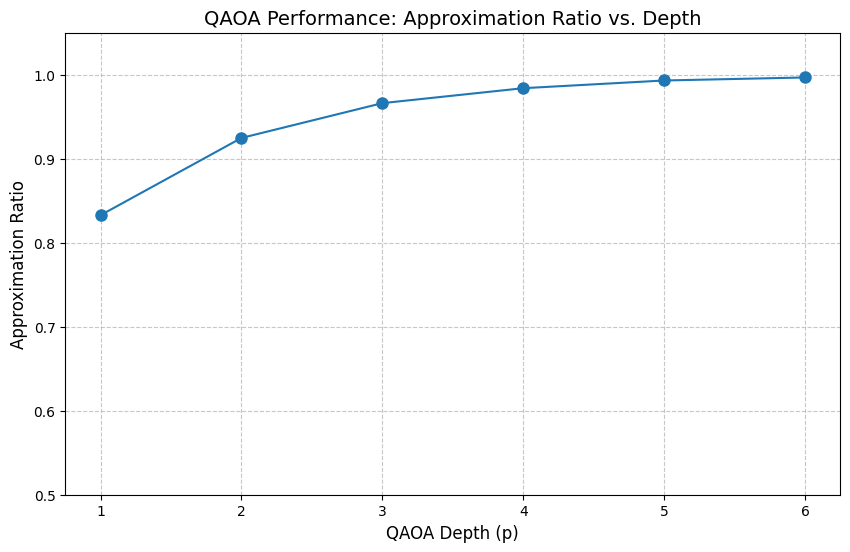

In [18]:
# TODO
import matplotlib.pyplot as plt
depths = np.arange(1, 7)
approximation_ratios = []

for p in depths:
    print(f"Running QAOA with depth {p}...")
    max_cut_value = run_qaoa(p)
    ratio = max_cut_value / (-ground_state_energy)
    approximation_ratios.append(ratio)
    print(f"Depth {p}: MaxCut = {max_cut_value:.3f}, Approximation Ratio = {ratio:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(depths, approximation_ratios, 'o-', markersize=8)
plt.xlabel("QAOA Depth (p)", fontsize=12)
plt.ylabel("Approximation Ratio", fontsize=12)
plt.title("QAOA Performance: Approximation Ratio vs. Depth", fontsize=14)
plt.xticks(depths)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0.5, 1.05)
plt.show()

## Q2 (c) Noise impact on performance
Add two-qubit depolarizing noise with error rates 0 (noiseless), 0.001, and 00.1 to CNOT gates and make the same plot with three curves, each corresponding to an error rate. This can take a while to run.


=== Running experiments with error rate: 0 ===
Processing depth 1...
Depth 1 | Error 0 | Ratio: 0.833
Processing depth 2...
Depth 2 | Error 0 | Ratio: 0.925
Processing depth 3...
Depth 3 | Error 0 | Ratio: 0.966
Processing depth 4...
Depth 4 | Error 0 | Ratio: 0.984
Processing depth 5...
Depth 5 | Error 0 | Ratio: 0.993
Processing depth 6...
Depth 6 | Error 0 | Ratio: 0.997

=== Running experiments with error rate: 0.001 ===
Processing depth 1...
Depth 1 | Error 0.001 | Ratio: 0.830
Processing depth 2...
Depth 2 | Error 0.001 | Ratio: 0.919
Processing depth 3...
Depth 3 | Error 0.001 | Ratio: 0.956
Processing depth 4...
Depth 4 | Error 0.001 | Ratio: 0.968
Processing depth 5...
Depth 5 | Error 0.001 | Ratio: 0.976
Processing depth 6...
Depth 6 | Error 0.001 | Ratio: 0.974

=== Running experiments with error rate: 0.01 ===
Processing depth 1...
Depth 1 | Error 0.01 | Ratio: 0.813
Processing depth 2...
Depth 2 | Error 0.01 | Ratio: 0.875
Processing depth 3...
Depth 3 | Error 0.01 | Rati

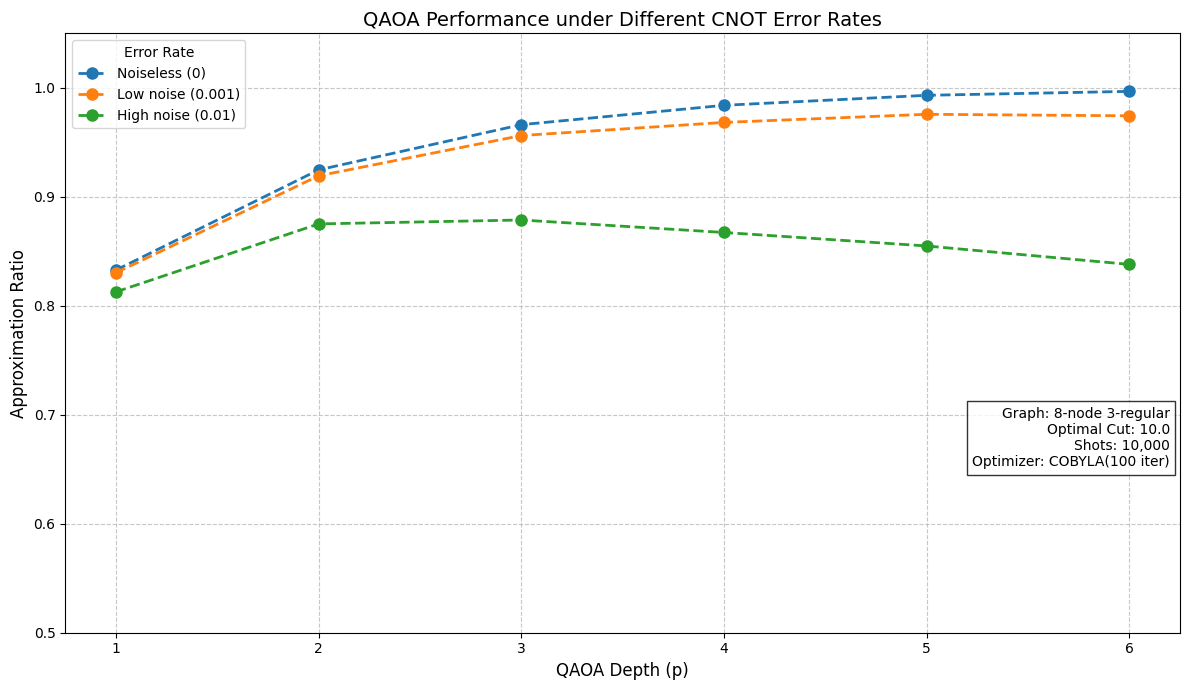

In [19]:
# TODO
from qiskit_aer.noise import NoiseModel, depolarizing_error
def create_noise_model(error_rate: float) -> NoiseModel | None:
    if error_rate == 0:
        return None

    noise_model = NoiseModel()
    cnot_error = depolarizing_error(error_rate, 2)
    noise_model.add_all_qubit_quantum_error(cnot_error, ['cx'])
    return noise_model

error_rates = [0, 0.001, 0.01]
noise_models = {rate: create_noise_model(rate) for rate in error_rates}

depths = np.arange(1, 7)
results = {rate: [] for rate in error_rates}


for rate in error_rates:
    print(f"\n=== Running experiments with error rate: {rate} ===")
    current_ratios = []

    for p in depths:
        print(f"Processing depth {p}...")
        max_cut = run_qaoa(p, noise_models[rate])
        ratio = max_cut / -ground_state_energy
        current_ratios.append(ratio)
        print(f"Depth {p} | Error {rate} | Ratio: {ratio:.3f}")

    results[rate] = current_ratios

plt.figure(figsize=(12, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
labels = [
    'Noiseless (0)',
    'Low noise (0.001)',
    'High noise (0.01)'
]

for (rate, color, label) in zip(error_rates, colors, labels):
    plt.plot(
        depths,
        results[rate],
        'o--',
        color=color,
        linewidth=2,
        markersize=8,
        label=label
    )

plt.xlabel("QAOA Depth (p)", fontsize=12)
plt.ylabel("Approximation Ratio", fontsize=12)
plt.title("QAOA Performance under Different CNOT Error Rates", fontsize=14)
plt.xticks(depths)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="Error Rate", fontsize=10)
plt.ylim(0.5, 1.05)

plt.text(
    6.2, 0.65,
    f"Graph: {n}-node 3-regular\n"
    f"Optimal Cut: {-ground_state_energy}\n"
    f"Shots: 10,000\n"
    f"Optimizer: COBYLA(100 iter)",
    ha='right', va='bottom',
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.tight_layout()
plt.savefig('qaoa_noise_comparison.png', dpi=300)
plt.show()

# Q3: Approximate Quantum Fourier Transform

The Quantum Fourier Transform (QFT) is an essential building block for other quantum algorithms such as Shor's factoring algorithm, quantum chemistry simulations etc.

se the following notebook as a reference for the rest of this question: https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/quantum-fourier-transform.ipynb

### Q3 (a): Construct the circuit for a 6-qubit *exact* QFT and simulate it for 10,000 shots (noiseless simulation). Report your result as a histogram (you can reuse code from HW2 for this).

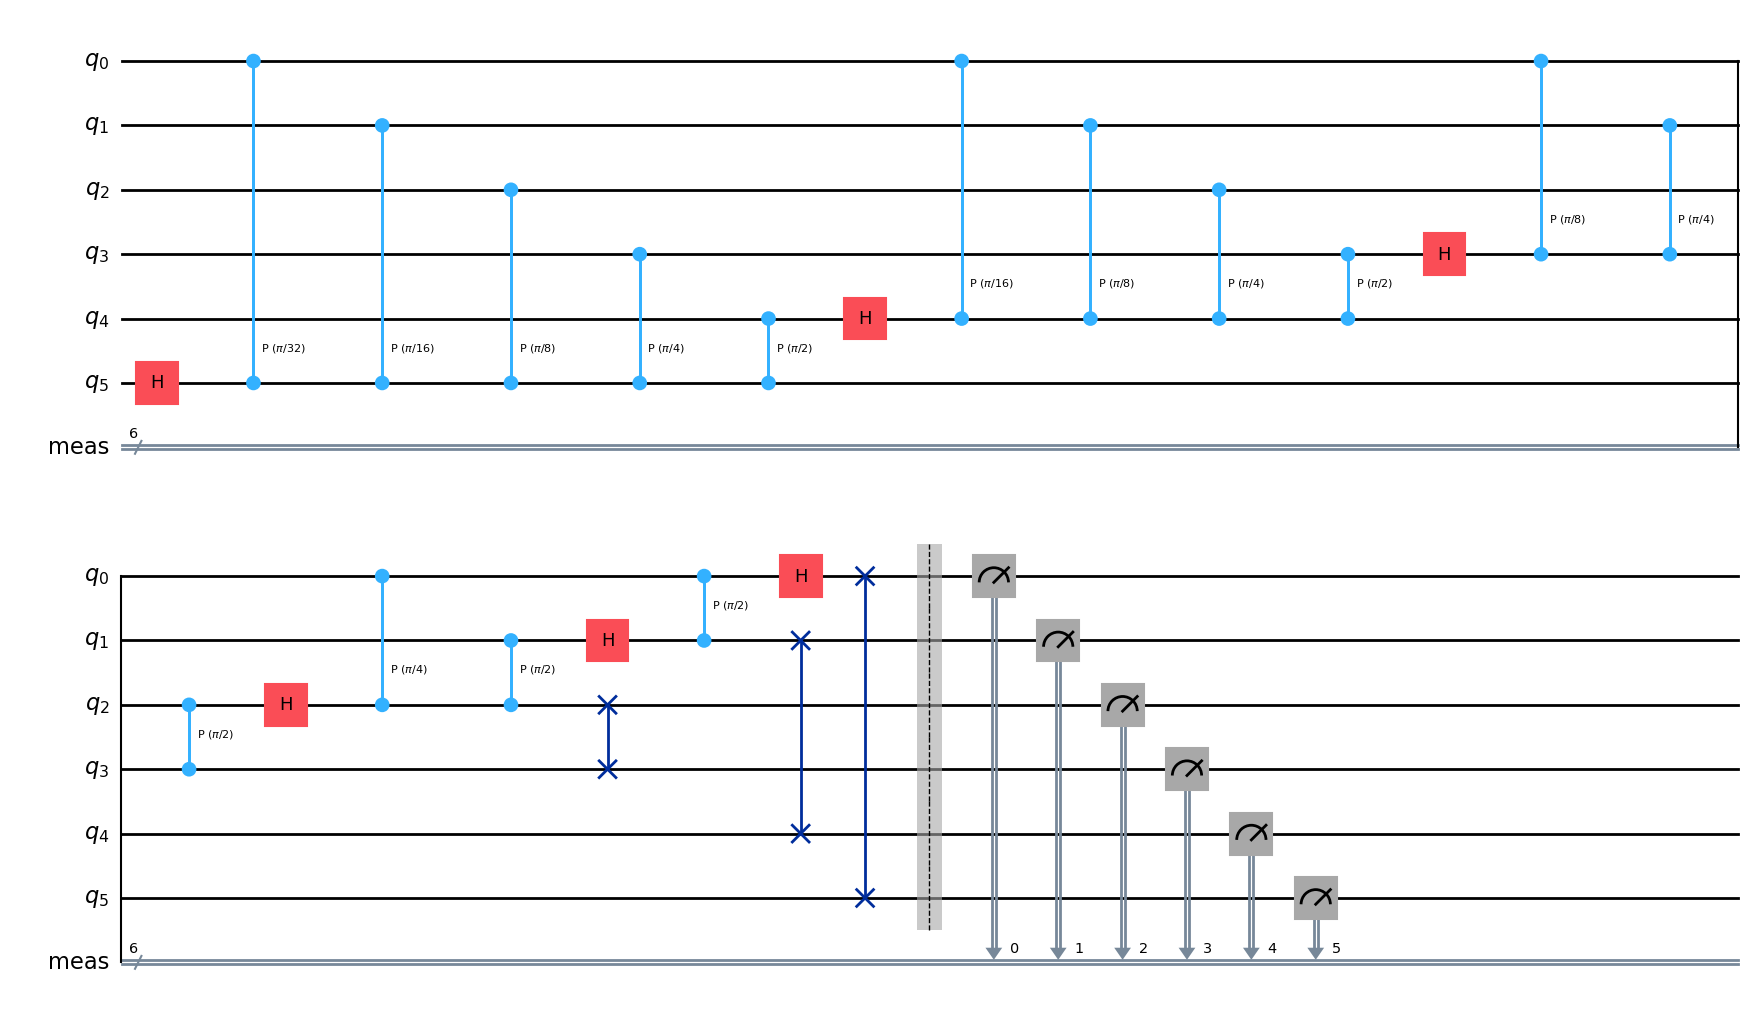

In [20]:
# Add your code here

def exact_QFT(circuit, n):
    def qft_rotations(circuit, n):
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
    for i in range(n, 0, -1):
        qft_rotations(circuit, i)
    for i in range(n // 2):
        circuit.swap(i, n - 1 - i)

circ = QuantumCircuit(6)
exact_QFT(circ, 6)
circ.measure_all()
circ.draw('mpl')

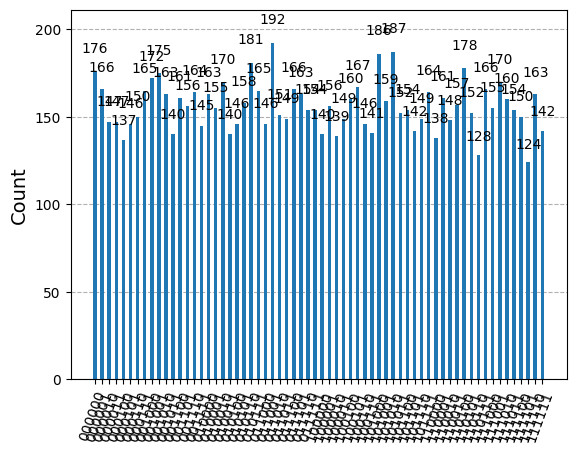

In [21]:
simulator = AerSimulator()

job = simulator.run(circ, shots=10000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

### Q3 (b): Now modify the circuit you created for an exact QFT to create the circuit for *approximate* QFT. Simulate the approximate QFT circuit using the same simulator and parameters used in part (a). Ignore all rotations smaller than $\pi/2^3$.

In approximate QFT, controlled phase rotations smaller than a threshold are ignored to reduce the total number of gates in the circuit. For more technical info on approximate QFT, refer to this paper: https://arxiv.org/abs/1803.04933.


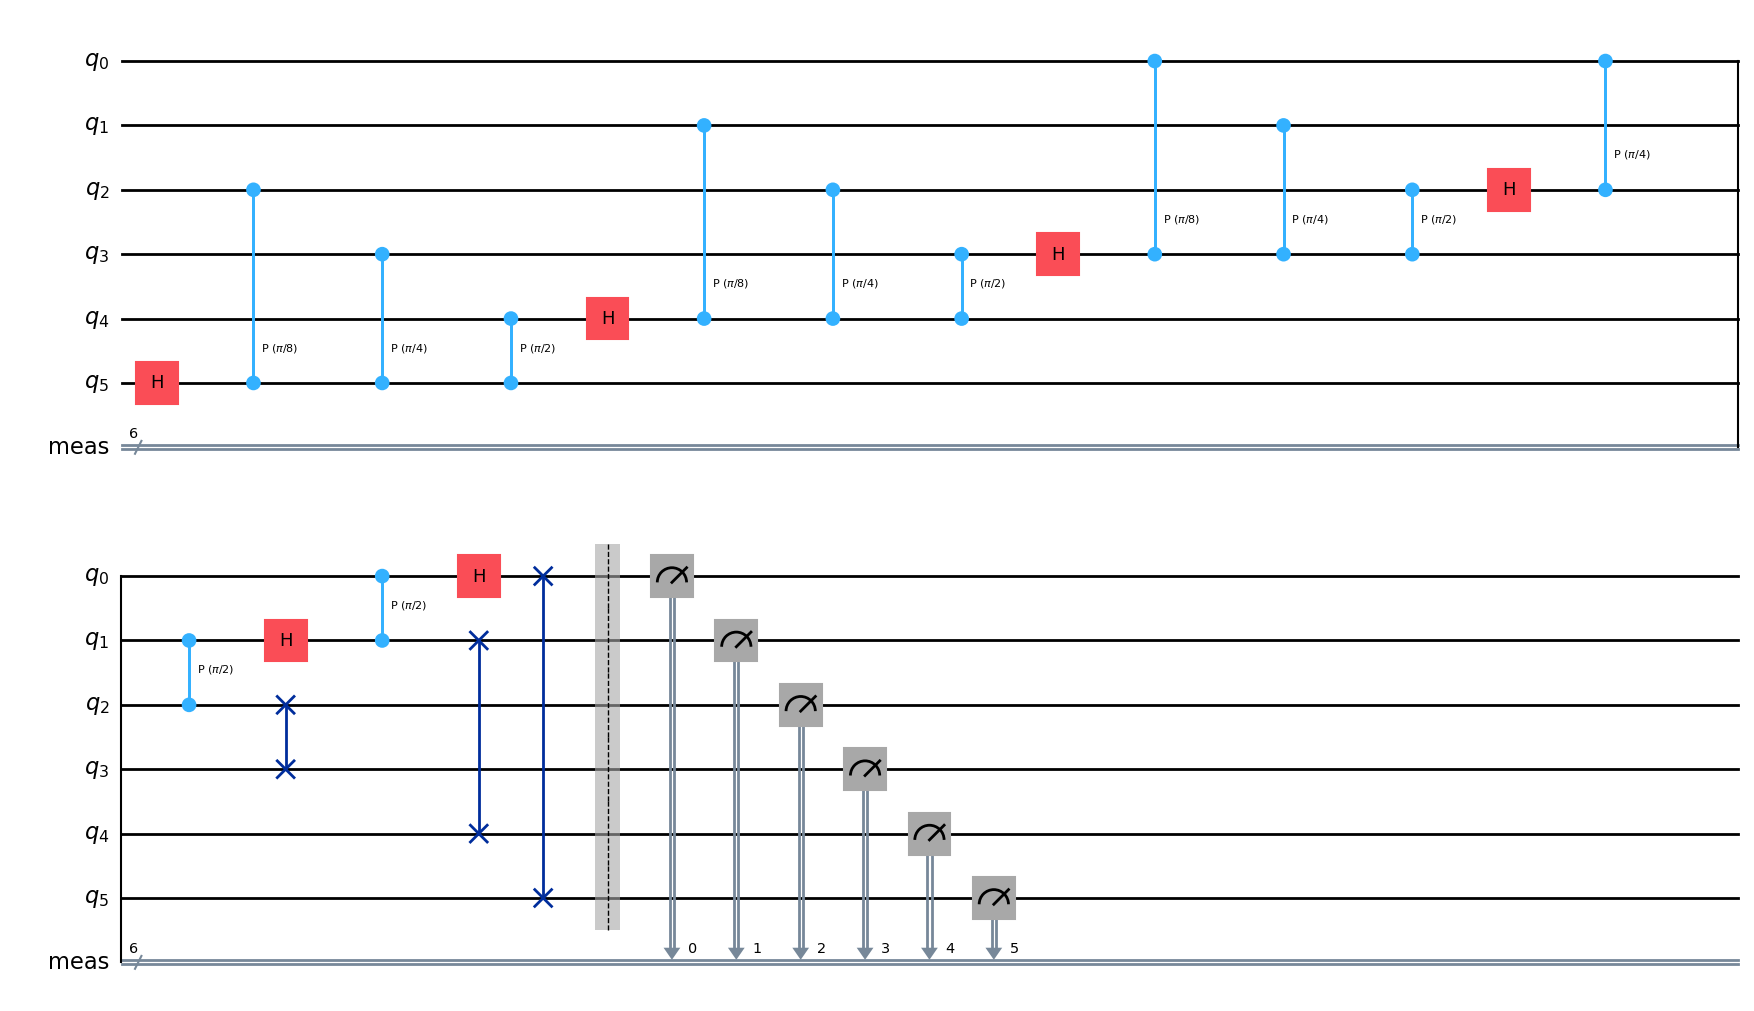

In [22]:
# Build, simulate, and plot the histogram for the approximate QFT circuit here

def approximate_QFT(circuit, n, threshold):
    def qft_rotations(circuit, n):
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            if np.pi/2**(n-qubit) < threshold:
                continue
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
    for i in range(n, 0, -1):
        qft_rotations(circuit, i)
    for i in range(n // 2):
        circuit.swap(i, n - 1 - i)

circ = QuantumCircuit(6)
approximate_QFT(circ, 6, np.pi / 8)
circ.measure_all()
circ.draw('mpl')

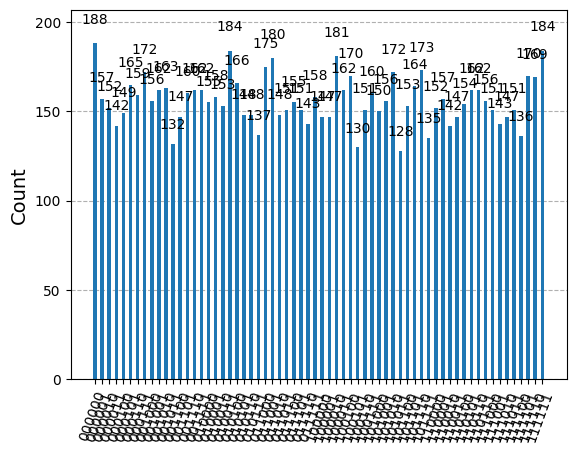

In [23]:
simulator = AerSimulator()

job = simulator.run(circ, shots=10000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

### Q3 (c): The cost of approximation is accuracy. Since we get a probability distribution from the QFT circuits, how would you compare the exact and approximate QFT circuits? State the method, and compute the metric you use for comparison.

To compare the exact and approximate QFT circuits, we can use the Total Variation Distance (TVD) as the metric. TVD measures the statistical difference between two probability distributions, with a value between 0 (identical) and 1 (completely different). Here’s the code to compute it:

In [44]:
def tvd(P, Q):
  return 0.5 * np.sum(np.abs(P - Q))

In [45]:
# Add your code here
n = 6
threshold = np.pi/8
shots = 1000

qc_exact = QuantumCircuit(n)
qc_exact.x(0)
qc_exact.x(5)
exact_QFT(qc_exact, n)
qc_exact.save_statevector()
qc_exact.measure_all()

qc_approx = QuantumCircuit(n)
qc_approx.x(0)
qc_approx.x(5)
approximate_QFT(qc_approx, n, threshold)
qc_approx.save_statevector()
qc_approx.measure_all()

simulator = AerSimulator()

job_exact = simulator.run(qc_exact, shots=shots)
state_exact = job_exact.result().get_statevector(qc_exact)

job_approx = simulator.run(qc_approx, shots=shots)
state_approx = job_approx.result().get_statevector(qc_approx)

print(state_exact, state_approx)

print(tvd(np.power(state_exact, 2), np.power(state_approx, 2)))

Statevector([ 1.25000000e-01-3.06161700e-17j,
             -1.24398091e-01-1.22521425e-02j,
              1.22598160e-01+2.43862903e-02j,
             -1.19617542e-01-3.62855847e-02j,
              1.15484942e-01+4.78354290e-02j,
             -1.10240158e-01-5.89245921e-02j,
              1.03933702e-01+6.94462791e-02j,
             -9.66263067e-02-7.92991605e-02j,
              8.83883476e-02+8.83883476e-02j,
             -7.92991605e-02-9.66263067e-02j,
              6.94462791e-02+1.03933702e-01j,
             -5.89245921e-02-1.10240158e-01j,
              4.78354290e-02+1.15484942e-01j,
             -3.62855847e-02-1.19617542e-01j,
              2.43862903e-02+1.22598160e-01j,
             -1.22521425e-02-1.24398091e-01j,
              3.82702125e-17+1.25000000e-01j,
              1.22521425e-02-1.24398091e-01j,
             -2.43862903e-02+1.22598160e-01j,
              3.62855847e-02-1.19617542e-01j,
             -4.78354290e-02+1.15484942e-01j,
              5.89245921e-02-1.102

### Q3 (d): Now change the threshold for the approximate QFT circuit to $\pi/2^4$ and compare this with the exact QFT circuit using the same metric used in part (c). How does this circuit compare with the earlier approximate QFT circuit which had a larger threshold?

In [46]:
# Add your code here
n = 6
threshold = np.pi/16
shots = 1000

qc_exact = QuantumCircuit(n)
qc_exact.x(0)
qc_exact.x(5)
exact_QFT(qc_exact, n)
qc_exact.save_statevector()
qc_exact.measure_all()

qc_approx = QuantumCircuit(n)
qc_approx.x(0)
qc_approx.x(5)
approximate_QFT(qc_approx, n, threshold)
qc_approx.save_statevector()
qc_approx.measure_all()

simulator = AerSimulator()

job_exact = simulator.run(qc_exact, shots=shots)
state_exact = job_exact.result().get_statevector(qc_exact)

job_approx = simulator.run(qc_approx, shots=shots)
state_approx = job_approx.result().get_statevector(qc_approx)

print(state_exact, state_approx)

print(tvd(np.power(state_exact, 2), np.power(state_approx, 2)))

Statevector([ 1.25000000e-01-3.06161700e-17j,
             -1.24398091e-01-1.22521425e-02j,
              1.22598160e-01+2.43862903e-02j,
             -1.19617542e-01-3.62855847e-02j,
              1.15484942e-01+4.78354290e-02j,
             -1.10240158e-01-5.89245921e-02j,
              1.03933702e-01+6.94462791e-02j,
             -9.66263067e-02-7.92991605e-02j,
              8.83883476e-02+8.83883476e-02j,
             -7.92991605e-02-9.66263067e-02j,
              6.94462791e-02+1.03933702e-01j,
             -5.89245921e-02-1.10240158e-01j,
              4.78354290e-02+1.15484942e-01j,
             -3.62855847e-02-1.19617542e-01j,
              2.43862903e-02+1.22598160e-01j,
             -1.22521425e-02-1.24398091e-01j,
              3.82702125e-17+1.25000000e-01j,
              1.22521425e-02-1.24398091e-01j,
             -2.43862903e-02+1.22598160e-01j,
              3.62855847e-02-1.19617542e-01j,
             -4.78354290e-02+1.15484942e-01j,
              5.89245921e-02-1.102

With a smaller threshold, the value of tvd get smaller. Which means it is more close to exact_QFT.

### Q3 (e): Now compare the gate counts of the exact QFT circuit with that of the two approximate QFT circuits you created.

In [47]:
# Add your code here
qc_exact = QuantumCircuit(6)
exact_QFT(qc_exact, 6)

qc_approx_a = QuantumCircuit(6)
approximate_QFT(qc_approx_a, 6, np.pi/8)

qc_approx_b = QuantumCircuit(6)
approximate_QFT(qc_approx_b, 6, np.pi/16)

print(f"Exact QFT: {qc_exact.count_ops()}")
print(f"Approximate QFT with threshold = pi/8: {qc_approx_a.count_ops()}")
print(f"Approximate QFT with threshold = pi/16: {qc_approx_b.count_ops()}")

Exact QFT: OrderedDict([('cp', 15), ('h', 6), ('swap', 3)])
Approximate QFT with threshold = pi/8: OrderedDict([('cp', 12), ('h', 6), ('swap', 3)])
Approximate QFT with threshold = pi/16: OrderedDict([('cp', 14), ('h', 6), ('swap', 3)])


# Q4: Quantum Phase Estimation (QPE)

Quantum Phase Estimation (QPE) is another essential building block for quantum algorithms, such as Shor's factoring algorithm. It uses QFT as a subroutine.
The problem in its simplest form is: given an eigenstate of a unitary operator, find its eigenvalue. We will walk through the main quantum part of Shor's factoring algorithm, which uses QPE for *order finding*. You may find this Pennylane tutorial to be helpful for learning more about QPE: https://pennylane.ai/qml/demos/tutorial_qpe.

We can reduce finding nontrivial factors of some positive integer $N$ to finding the *order* of some integer $1 < a < N$ such that the greatest common divisor (gcd) of $a$ and $N$ is 1. That is, $a$ and $N$ are *co-prime*.

The order of $a$ mod $N$ is defined to be the *least* positive integer, $r$, such that $x^r = 1(\text{ mod }N)$. For example, the order of 4 mod 15 is 2 because $4^1 \text{ mod } 15 = 4 \text{ mod } 15 \neq 1 \text{ mod } 15$. But $4^2 \text{ mod } 15 = 16 \text{ mod } 15 = 1 \text{ mod } 15$.

If we find the order $r$ of $a$ mod $N$ and $r$ is even AND $g := $ gcd($a^{r/2} - 1$, $N$) is nontrivial (not 1 or $N$) THEN $g$ is a nontrivial factor of $N$. Hopefully you are convinced that all we need to do to factor is somehow find this order $r$. It's not so easy though. Order-finding is believed to be hard on a classical computer.


### Q4 (a)
What is the relationship between the unitary operator $U|y\rangle := |ay(\text{mod } N)\rangle$ and this expression that contains $r$, the order of $a$ mod $N$: $e^{2\pi i \frac{s}{r}}$? $s$ is just some integer. (Hint: $U$ is the unitary operator that we want to apply QPE to with one of its eigenstates as input)

TODO: type your short answer here

### Q4 (b)

You may have noticed that what we actually get from QPE is an estimate of $s/r$, not $r$ directly. This is not a problem though because we have an efficient algorithm based on *continued fractions* to extract $r$.

Here is a picture of a QPE circuit where $|\psi\rangle$ is an eigenstate of $U$ and we measure out $\theta$, the *phase* of the eigenvalue of $|\psi\rangle$. So for order finding $\theta = s/r$.

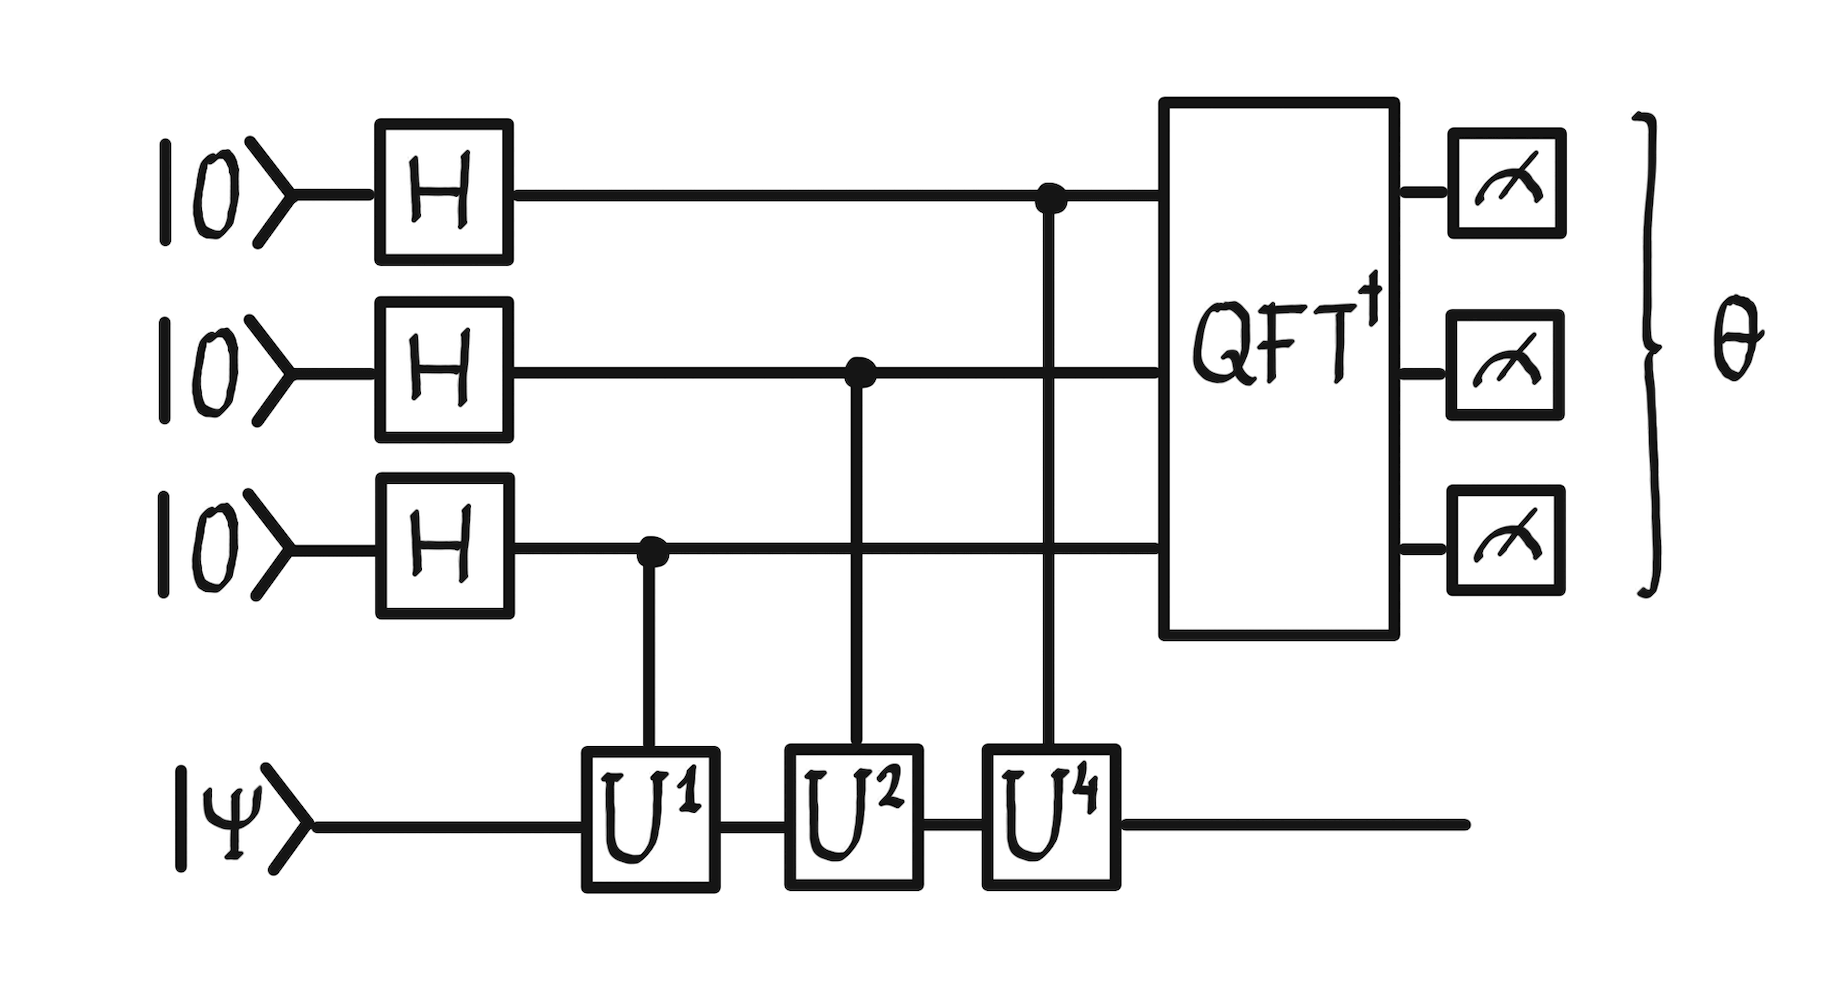

For order finding, what should the eigenstate $|\psi\rangle$ be?

TODO: type your short answer here

### Q4 (c)

The controlled $U$ gates are the hardest part to implement in order finding because they are performing modular exponentiation. For now, we'll consider a simpler case so we can understand the internals of QPE a little better.


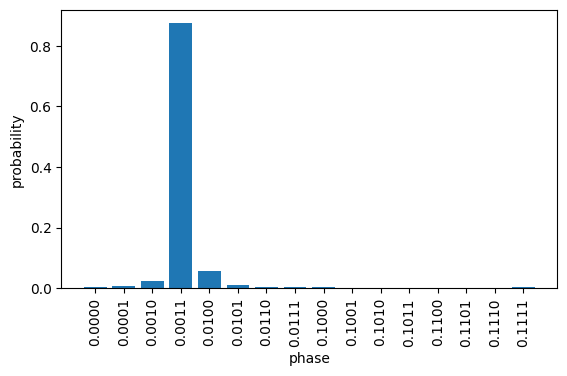

In [27]:
# Here is code from the tutorial linked in the beginning of Q4
import pennylane as qml
import numpy as np

def U(wires):
    return qml.PhaseShift(2 * np.pi / 5, wires=wires)

dev = qml.device("default.qubit")

@qml.qnode(dev)
def circuit_qpe(estimation_wires):
    # initialize to state |1>
    qml.PauliX(wires=0)

    for wire in estimation_wires:
        qml.Hadamard(wires=wire)

    qml.ControlledSequence(U(wires=0), control=estimation_wires)

    qml.adjoint(qml.QFT)(wires=estimation_wires)

    return qml.probs(wires=estimation_wires)

import matplotlib.pyplot as plt

estimation_wires = range(1, 5)

results = circuit_qpe(estimation_wires)

bit_strings = [f"0.{x:0{len(estimation_wires)}b}" for x in range(len(results))]

plt.bar(bit_strings, results)
plt.xlabel("phase")
plt.ylabel("probability")
plt.xticks(rotation="vertical")
plt.subplots_adjust(bottom=0.3)

plt.show()

Try removing the inverse QFT step and plot the resulting histogram.

In [28]:
# Insert code here to plot histogram after removing inverse QFT

What do you observe about the output now? Can you still infer the phase?

TODO: type your short answer here

To dig a little deeper, the state we have before the inverse QFT is $$\frac{1}{2^{n/2}}\sum_{x=0}^{2^n-1}e^{2\pi i \theta x}|x\rangle$$ Does $\theta$, the phase we want to extract, contribute at all to any of the outcome probabilities? Why or why not?

TODO: type your short answer here

### Q4 (d)

What happens if the input $|\psi\rangle$ is not an eigenstate of $U$? Does QPE still work or will we simply measure garbage?

TODO: type your short answer here

# Q5: Quantum Machine Learning

Machine Learning has significantly benefited from Convolutional Neural Networks (CNNs), which extract spatial features from image data using convolutional and pooling layers. However, as quantum computing progresses, researchers have started exploring quantum analogs of CNNs that leverage quantum circuits to perform convolution-like operations.



## Q5 (a): Quantum Convolution

In this problem, you will explore the quantum approach of using Quantum Convolution to image classification of MNIST Dataset. Quantum Convolution uses small quantum circuits to extract quantum-enhanced features from classical image data before feeding them into a classical neural network.

Reference: [Quanvolutional Neural Networks: Powering
Image Recognition with Quantum Circuits](https://arxiv.org/abs/1904.04767).

Credits: Borrowed the setup and training by [Andrea Mari](https://pennylane.ai/profile/amari) on [Quanvolutional Neural Networks](https://pennylane.ai/qml/demos/tutorial_quanvolution)

In [29]:
epochs = 40          # Number of optimization epochs
random_layers = 1    # Number of random layers
train_samples = 500        # Size of the train dataset
test_samples = 100         # Size of the test dataset

FOLDER_PATH = ""            # Add the folder path to save the data
np.random.seed(0)
tf.random.set_seed(0)




NameError: name 'tf' is not defined

Load MNIST dataset and normalize the images. Use train_samples for training and test_samples for testing. The tutorial on [Quanvolutional Neural Networks](https://pennylane.ai/qml/demos/tutorial_quanvolution) will aid you for 5(a).

In [ ]:
## Load MNIST Dataset
#  Use reduced dataset with train_samples for training and test_samples for testing


train_images, train_labels, test_images, test_labels = ...


We implement quantum convolution kernel using quantum circuit. The circuit consists of, layer of local $R_{y}$ rotations (angles scaled by a factor of $\pi$), then a random circuit and finally a measurement in the computation basis, estimating the expectation values.

For this implementation we use a system of 4 qubits.

In [ ]:
## Circuit for quantum convolution
#  Takes input as angles for the R_Y layer

n_wires = 4
dev = qml.device("default.mixed", wires=n_wires)
# Random circuit parameters
rand_params = ...

@qml.qnode(dev)
def circuit(angles):
    # Entangling Layer of Ry

    # Random quantum circuit (Check RandomLayers in pennylane)

    # Final measurement estimating expectation values as 4 classical outputs
    return



In the next function, we divide the image into 2x2 squares and apply the above quantum circuit to perform quantum convolution.

In [ ]:
def quanvolve(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = ..

    # Loop over the coordinates of the image in 2X2 squares
    # Process each 2x2 region of the image with the above quantum circuit

    return out

In [ ]:
## Quantum pre-processing of train and test images
#  Do not modify the following code

quanvolve_train_images = np.array([quanvolve(image) for image in train_images])
quanvolve_test_images = np.array([quanvolve(image) for image in test_images])


In [ ]:
## ML model and training
#  Do not modify the following code

def BaseModel():
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

quanvolve_model = BaseModel()

quanvolve_history = quanvolve_model.fit(
    quanvolve_train_images.reshape(-1,28,28,1),
    train_labels,
    validation_data=(quanvolve_test_images.reshape(-1,28,28,1), test_labels),
    batch_size=4,
    epochs=epochs,
    verbose=2,
)

In [ ]:
## Classical model

classical_model = BaseModel()

classical_history = classical_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Compare the performance of Quanvolve vs Classical models based on accuracy.

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(quanvolve_history.history["val_accuracy"], "-ob", label="Quanvolve")
ax1.plot(classical_history.history["val_accuracy"], "-og", label="Classical")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(quanvolve_history.history["val_loss"], "-ob", label="Quanvolve")
ax2.plot(classical_history.history["val_loss"], "-og", label="Classical")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

## Q5 (b) Impact of gate noise

In the quantum circuit in the function `circuit`, add depolarizing noise to the $R_{Y}$ gates using pennylane `DepolarizingChannel` varying the error probability from 0 to 1 in steps of 1/4. Explain the impact of noise on accuracy.

## Q5 (c)

Instead of the `BaseModel` described above use the `CNNModel` given below and plot the variation of accuracy with epochs for Quanvolve and Classical similar to Q5(a). Comment on the impact of Quantum Kernel for this case.

In [ ]:
input_shape = (28, 28, 1)
def CNNModel():
    model = keras.models.Sequential([
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(10, activation="softmax"),
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model